# Интерпретация результатов AB-теста

* [Вступление](#id_1)
  * [используемые библиотеки](#id_1a)
  * [Цель проекта](#id_1b)
  * [Описание данных](#id_1c)
  * [Файлы](#id_1d)
  * [Начальная предобработка](#id_1e)
* [Приоритизация гипотез](#id_2)
  * [Фреймворк ICE](#id_2a)
  * [Фреймворк RICE](#id_2b)
  * [Выводы](#id_2c)
* [Анализ АВ-теста](#id_3)
  * [Создание таблицы данных](#id_3a)
  * [Проверка данных на нормальность](#id_3aa)
  * [Проверка на правильность размера групп](#id_3ab)
  * [График кумулятивной выручки по группам](#id_3b)
  * [график кумулятивной конверсии по группам](#id_3ba)
  * [График кумулятивного среднего чека по группам](#id_3c)
  * [График относительного изменения кумулятивного среднего чека группы B к группе A](#id_3d)
  * [График кумулятивного среднего количества заказов на посетителя по группам](#id_3e)
  * [График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A](#id_3f)
  * [Точечный график количества заказов по пользователям](#id_3g)
  * [95-й и 99-й перцентили количества заказов на пользователя](#id_3h)
  * [Tочечный график стоимостей заказов](#id_3j)
  * [ 95-й и 99-й перцентили стоимости заказов](#id_3k)
  * [Cтатистическая значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным](#id_3l)
  * [Статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным](#id_3m)
  * [Cтатистическая значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным](#id_3n)
  * [Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным](#id_3o)
* [Общий вывод](#id_4)

## Вступление <a class="anchor" id="id_1"></a> 

### Используемые библиотеки <a class="anchor" id="id_1a"></a>

In [30]:
import pandas as pd
import os
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
sns.set_style("dark")
pd.set_option('max_colwidth', 400)

### Цель проекта <a class="anchor" id="id_1b"></a>

Как аналитику крупного интернет-магазина, мне нужно приоритизировать представленные гипотезы для увеличения выручки, выбрать приоритетные, запустить АВ-тест и проанализировать его результаты.

### Описание данных <a class="anchor" id="id_1c"></a>

Таблица hypothesis:  
- Hypothesis — краткое описание гипотезы;
- Reach — охват пользователей по 10-балльной шкале;
- Impact — влияние на пользователей по 10-балльной шкале;
- Confidence — уверенность в гипотезе по 10-балльной шкале;
- Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

Таблица orders:  
- transactionId — идентификатор заказа;
- visitorId — идентификатор пользователя, совершившего заказ;
- date — дата, когда был совершён заказ;
- revenue — выручка заказа;
- group — группа A/B-теста, в которую попал заказ.

Таблица visitors:  
- date — дата;
- group — группа A/B-теста;
- visitors — количество пользователей в указанную дату в указанной группе A/B-теста

### Файлы <a class="anchor" id="id_1d"></a>

In [32]:
hypothesis = pd.read_csv(path + r'\hypothesis.csv', sep=',')
orders = pd.read_csv(path + r'\orders.csv', sep=',')
visitors = pd.read_csv(path + r'\visitors.csv', sep=',')

### Начальная предобработка <a class="anchor" id="id_1e"></a>

In [33]:
display(orders.info())
print('-'*20)
display(visitors.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


None

--------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


None

Поиск дубликатов:

In [34]:
print(orders.duplicated().sum())
print(visitors.duplicated().sum())

0
0


Пропусков в данных нет, дубликатов нет, заголовки корректные.
Преобразование дат в формат datetime:

In [35]:
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

## Приоритизация гипотез <a class="anchor" id="id_2"></a>

In [36]:
display(hypothesis.head())

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1


### Фреймворк ICE для приоритизации гипотез. <a class="anchor" id="id_2a"></a>


Формула подсчета:    
$ ICE\_SCORE = \frac{Impact*Confidence}{Efforts}$,    
где:
* Impact — насколько сильно изменение повлияет на пользователей, их опыт и удовлетворение от продукта;
* Confidence — насколько вы уверены, что это изменение повлияет на пользователей именно так;
* Efforts — сколько стоит протестировать эту гипотезу.

Вычисление:

In [37]:
hypothesis['ICE'] =  (hypothesis['Impact'] * hypothesis['Confidence'] / hypothesis['Efforts']).round(2)
display(hypothesis.sort_values('ICE', ascending = False))

,Hypothesis,Reach,Impact,Confidence,Efforts,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00


### Фреймворк RICE для приоритизации гипотез. <a class="anchor" id="id_2b"></a>


Формула подсчета:  
$ RICE\_SCORE = \frac{Reach*Impact*Confidence}{Efforts}$,
    
где:
* Reach — скольких пользователей затронет изменение, которое вы хотите внести;
* Impact — насколько сильно изменение повлияет на пользователей, их опыт и удовлетворение от продукта;
* Confidence — насколько вы уверены, что это изменение повлияет на пользователей именно так;
* Efforts — сколько стоит протестировать эту гипотезу.

Вычисление:

In [38]:
hypothesis['RICE'] =  (hypothesis['Reach'] * hypothesis['Impact'] * hypothesis['Confidence'] / hypothesis['Efforts']).round(2)
display(hypothesis.sort_values('RICE', ascending = False))

,Hypothesis,Reach,Impact,Confidence,Efforts,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00,3.0


### Выводы <a class="anchor" id="id_2с"></a>

При применении метода Rice самой приоритетной стала гипотеза "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок" за счет показателя охвата 10, т.е она затронет всех пользователей. Также она может благотворно сказаться на пользовательском опыте, поможет собрать базу лояльных покупателей при средних издержках на ее внедрение. Гипотеза-лидер по методу ICE - "Запустить акцию, дающую скидку на товар в день рождения" - не изменила значение по методу RICE, так как имеет минимальный показатель охвата, равный 1, т.е затронет только тех покупателей, которые зайдут в магазин по случаю дня рождения (их количество зависит от ассортимента магазина и количества покупателей).  
Наблюдая за динамикой изменений в обеих таблицах можно сделать вывод, что по методу RICE на первый план выходят гипотезы с охватом как-можно большей аудитории при средних и выше средних значениях *Impact*  и *Confidence* и при средних и меньше издержках на их внедрение. Гипотезы с маленьким охватом имеют шанс попасть в лидеры, если они гарантированно сильно улучшают пользовательский опыт, а их внедрение обойдется в копейки.

## Анализ A/B-теста <a class="anchor" id="id_3"></a>

### Создание таблицы данных <a class="anchor" id="id_3a"></a>

In [39]:
display(visitors.head())

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [40]:
display(orders.head())

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


Создание объединенной таблицы:

In [41]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

# Вычисление нарастающего количества посетителей по группам
visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

# Подсчет количества заказов по дням и выручки
ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']
# Вычисление нарастающего количества заказов по дням и кумулятивной выручки по группам
ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

# Объединение таблиц
data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)
# Создание колонок кумулятивного среднего чека по группам
data['cum_average_billA'] = (data['revenueCummulativeA'] / data['visitorsCummulativeA']).round(3)
data['cum_average_billB'] = (data['revenueCummulativeB'] / data['visitorsCummulativeB']).round(3)

In [42]:
display(data.head(5)) 

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB,cum_average_billA,cum_average_billB
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713,206.647,141.959
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294,181.167,206.142
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803,192.344,211.312
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573,166.159,190.271
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280,165.737,177.438


Названия столбцов данных:  

* date — дата;
* ordersPerDateA       — количество заказов в выбранную дату в группе A;
* revenuePerDateA      — суммарная выручка в выбранную дату в группе A;
* ordersPerDateB       — количество заказов в выбранную дату в группе B;
* revenuePerDateB      — суммарная выручка в выбранную дату в группе B;
* ordersCummulativeA   — суммарное число заказов до выбранной даты включительно в группе A;
* revenueCummulativeA  — суммарная выручка до выбранной даты включительно в группе A;
* ordersCummulativeB   — суммарное количество заказов до выбранной даты включительно в группе B;
* revenueCummulativeB  — суммарная выручка до выбранной даты включительно в группе B;
* visitorsPerDateA     — количество пользователей в выбранную дату в группе A;
* visitorsPerDateB     — количество пользователей в выбранную дату в группе B;
* visitorsCummulativeA — количество пользователей до выбранной даты включительно в группе A;
* visitorsCummulativeB — количество пользователей до выбранной даты включительно в группе B.
* cum_average_billA - кумулятивный средний чек у группы А
* cum_average_billB - кумулятивный средний чек у группы B

### Проверка данных на нормальность распределения <a class="anchor" id="id_3aa"></a>

Для проверки использую критерий Шапиро-Уилкса:

In [43]:
#Проверка колонки orders['revenue']
alpha = 0.05  # критический уровень статистической значимости

results = st.shapiro(orders['revenue'])
p_value = results[1]  # второе значение в массиве результатов (с индексом 1) - p-value

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: распределение revenue не нормально')
else:
    print('Не получилось отвергнуть нулевую гипотезу, распределение revenue  нормально')

p-значение:  0.0
Отвергаем нулевую гипотезу: распределение revenue не нормально


In [44]:
#Проверка колонки visitors['visitors']
alpha = 0.05  # критический уровень статистической значимости

results = st.shapiro(visitors['visitors'])
p_value = results[1]  # второе значение в массиве результатов (с индексом 1) - p-value

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: распределение visitors не нормально')
else:
    print('Не получилось отвергнуть нулевую гипотезу, распределение visitors  нормально')

p-значение:  0.002020221436396241
Отвергаем нулевую гипотезу: распределение visitors не нормально


**Вывод:**  
Данные о выручке и числе покупателей не нормальны и могут содержать выбросы.

### Проверка на правильность размера выборок <a class="anchor" id="id_3ab"></a>

In [45]:
display(visitors.groupby('group')['visitors'].sum())
print(visitors['visitors'].sum())

group
A    18736
B    18916
Name: visitors, dtype: int64

37652


Так как данные распределены не нормально, для проверки статистической значимости между размерами групп будет использоваться тест Уилкоксона-Манна-Уитни

In [46]:
sampleA = visitors.query('group=="A"')['visitors']
sampleB = visitors.query('group=="B"')['visitors']
alpha = 0.05  # критический уровень статистической значимости

results = st.mannwhitneyu(sampleA, sampleB)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница между размерами групп статистически значима')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, статистической разницы между размерами групп нет'
    )

p-значение:  0.7301376549390499
Не получилось отвергнуть нулевую гипотезу, статистической разницы между размерами групп нет


In [47]:
baseline_conversion = (
    len(orders.query('group=="A"').groupby('visitorId')) / (visitors.query('group=="A"')['visitors'].sum())*100).round(3)
new_conversion = (
    len(orders.query('group=="B"').groupby('visitorId')) / (visitors.query('group=="B"')['visitors'].sum())*100).round(3)
relative_change = abs(baseline_conversion / new_conversion-1)
print('Первоначальная конверсия %: ',baseline_conversion,
      '\nПолученная конверсия %: ',new_conversion, '\nОтносительное изменение конверсии %: ', relative_change)

Первоначальная конверсия %:  2.685 
Полученная конверсия %:  3.098 
Относительное изменение конверсии %:  0.13331181407359582


Используя калькулятор для расчета размера выборок http://www.evanmiller.org/ab-testing/sample-size.html и вводя полученные данные Baseline Conversion Rate = 2.685 и Minimum Detectable Effect(relative) = 13.33 при Statistical power = 80% и Significance level = 5%, получаю размер выборки 32634. Получается, план по количеству перевыполнен на 5000 человек.  


**Вывод:**  
Статистической разницы между размерами групп нет, покупатели для теста распределены правильно. Размер выборки подходящий.

### График кумулятивной выручки по группам <a class="anchor" id="id_3b"></a>

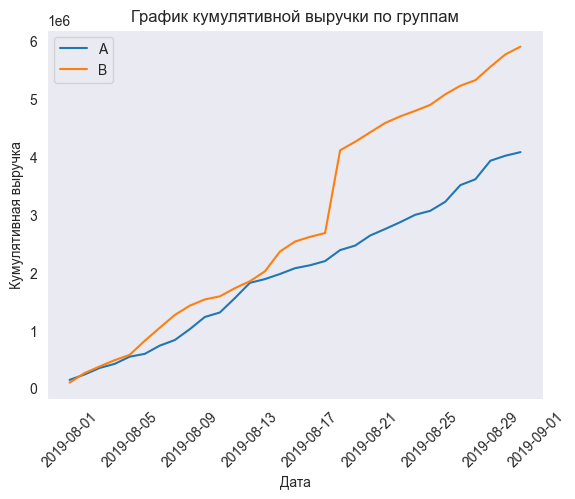

In [48]:
sns.lineplot(x='date', y='revenueCummulativeA', data=data, label = 'A')
sns.lineplot(x='date', y='revenueCummulativeB', data=data, label = 'B')
plt.xlabel("Дата")
plt.ylabel("Кумулятивная выручка")
plt.title("График кумулятивной выручки по группам")
plt.xticks(rotation=45)
plt.legend()
plt.show()

**Выводы и предположения:**    
Кумулятивная выручка по группам сначала мало отличается, но затем, примерно в середине наблюдаемого периода, у группы B она сильно уходит в отрыв и дальше у обоих групп она продолжает плавно возрастать. Может быть, это вызвано тем, что в тот период времени были сделаны аномально большие покупки.

### График кумулятивной конверсии <a class="anchor" id="id_3ba"></a>

Расчет по группам:  кумулятивное количество заказов делится на кумулятивное число посетителей

In [49]:
data['cumulative_conversionA%'] = (data['ordersCummulativeA'] / data['visitorsCummulativeA']*100).round(2)
data['cumulative_conversionB%'] = (data['ordersCummulativeB'] / data['visitorsCummulativeB']*100).round(2)

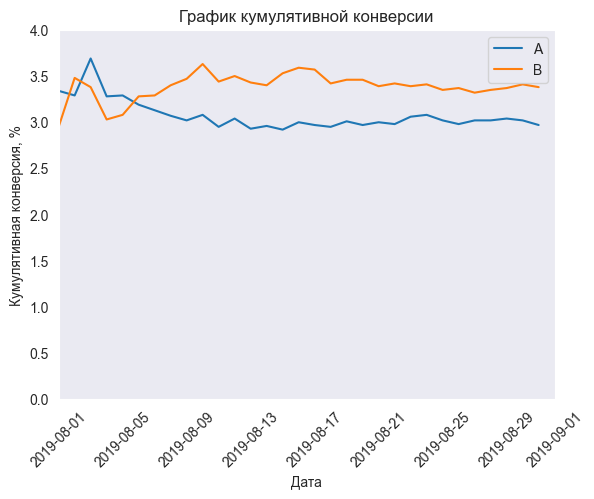

In [50]:
sns.lineplot(x='date', y='cumulative_conversionA%', data=data, label = 'A')
sns.lineplot(x='date', y='cumulative_conversionB%', data=data, label = 'B')
plt.xlabel("Дата")
plt.ylabel("Кумулятивная конверсия, %")
plt.title("График кумулятивной конверсии")
plt.xticks(rotation=45)
plt.legend()
plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 9, 1), 0, 4])
plt.show()

In [51]:
data ['relative_cum_convB'] = data['cumulative_conversionB%'] / data['cumulative_conversionA%'] - 1

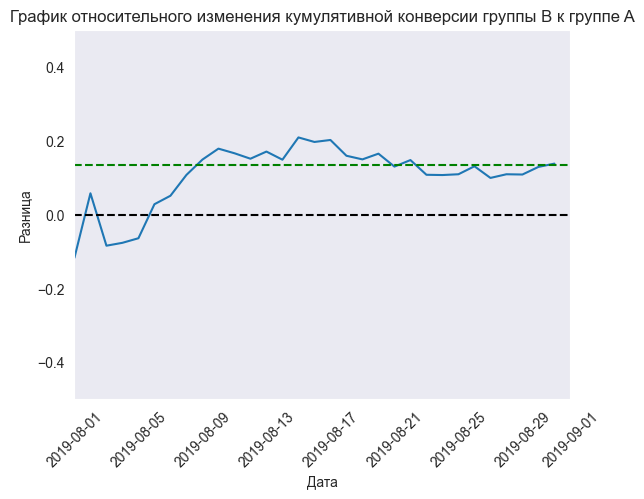

In [52]:
sns.lineplot(x='date', y='relative_cum_convB', data=data)
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel("Дата")
plt.ylabel("Разница")
#Полученное относительное изменение конверсии
plt.axhline(y=relative_change, color='green', linestyle='dashed')
plt.title("График относительного изменения кумулятивной конверсии группы B к группе A")
plt.xticks(rotation=45)
plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 9, 1), -0.5, 0.5])
plt.show()

**Выводы:**  
Графики кумулятивных конверсий групп после недели начальных колебаний выровнялись на отметках 3.5% для группы В и 3% для группы A. У группы В показатель к концу теста примерно на 15% лучше, чем у группы А.

### График кумулятивного среднего чека по группам. <a class="anchor" id="id_3c"></a>

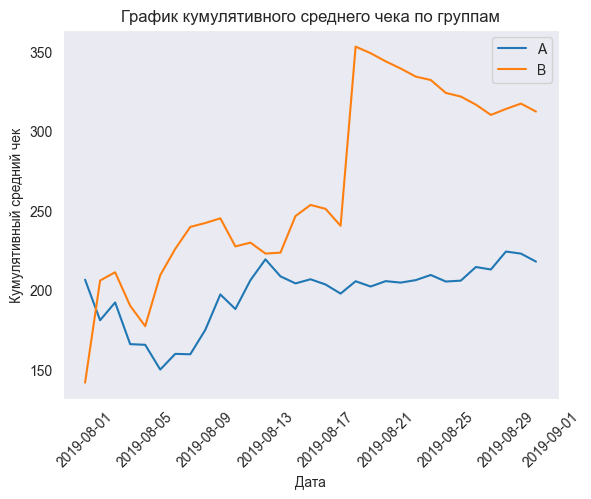

In [53]:
sns.lineplot(x='date', y='cum_average_billA', data=data, label = 'A')
sns.lineplot(x='date', y='cum_average_billB', data=data, label = 'B')
plt.xlabel("Дата")
plt.ylabel("Кумулятивный средний чек")
plt.title("График кумулятивного среднего чека по группам")
plt.xticks(rotation=45)
plt.legend()
plt.show()

**Выводы и предположения:**    
Кумулятивный средний чек по группам сильно колеблется, в середине наблюдаемого периода у группы В он резко вырос с 250 до 350 рублей, необходимо проверить данные о заказах насчет аномалий.

### График относительного изменения кумулятивного среднего чека группы B к группе A.  <a class="anchor" id="id_3d"></a>

Создание колонки с данными:

In [54]:
data['relative_cum_avr_billB'] = data['cum_average_billB'] / data['cum_average_billA'] - 1

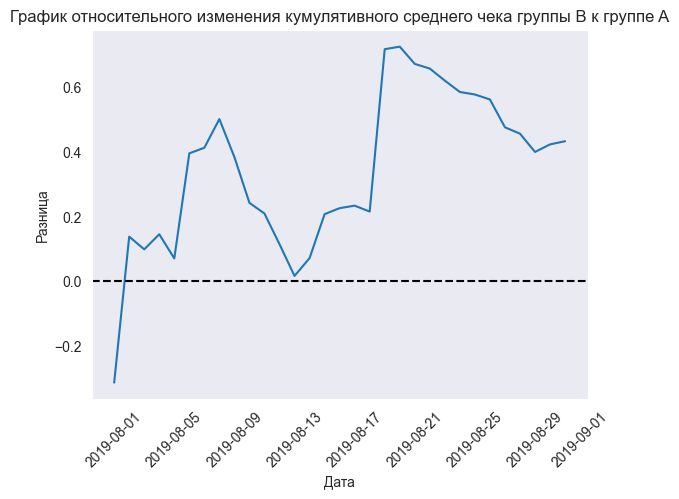

In [55]:
sns.lineplot(x='date', y='relative_cum_avr_billB', data=data)
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel("Дата")
plt.ylabel("Разница")
plt.title("График относительного изменения кумулятивного среднего чека группы B к группе A")
plt.xticks(rotation=45)
plt.show()

**Выводы и предположения:**      
График резко колеблется в несколько дат, когда были совершены большие заказы. К концу наблюдаемого периода после всех колебаний кумулятивный средний чек группы B был на 40% выше, чем у группы А и продолжал плавно расти.

### График кумулятивного среднего количества заказов на посетителя по группам. <a class="anchor" id="id_3e"></a>

Создание колонки с данными:

In [56]:
data['cum_average_ordersA'] = (data['ordersCummulativeA'] / data['visitorsCummulativeA']).round(3)
data['cum_average_ordersB'] = (data['ordersCummulativeB'] / data['visitorsCummulativeB']).round(3)

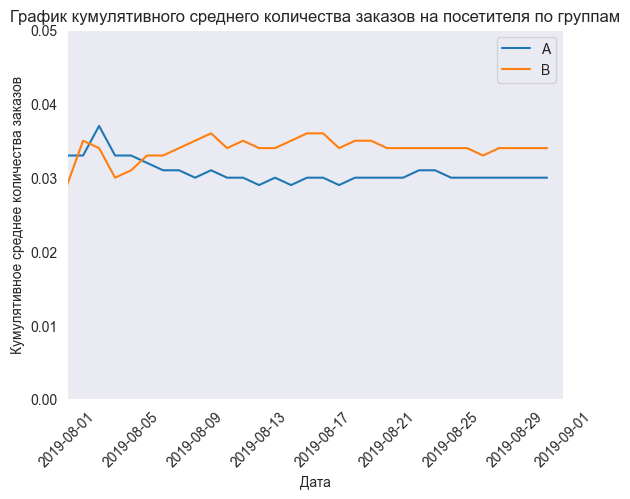

In [57]:
sns.lineplot(x='date', y='cum_average_ordersA', data=data, label = 'A')
sns.lineplot(x='date', y='cum_average_ordersB', data=data, label = 'B')
plt.xlabel("Дата")
plt.ylabel("Кумулятивное среднее количества заказов")
plt.title("График кумулятивного среднего количества заказов на посетителя по группам")
plt.xticks(rotation=45)
plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 9, 1), 0, 0.05])
plt.legend()
plt.show()

**Выводы и предположения:**      
Колебания очень незначительные в пределах 0.03 - 0.04 количества заказов на посетителя, но после начальных колебаний у группы В они выше. 

### График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A. <a class="anchor" id="id_3f"></a>

Создание колонки с данными:

In [58]:
data ['relative_cum_avr_ordersB'] = data['cum_average_ordersB'] / data['cum_average_ordersA'] -1

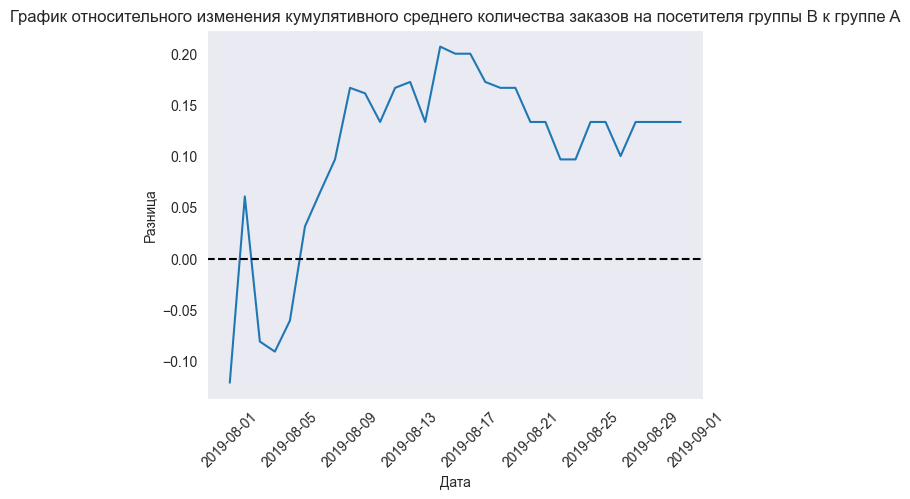

In [59]:
sns.lineplot(x='date', y='relative_cum_avr_ordersB', data=data)
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel("Дата")
plt.ylabel("Разница")
plt.title("График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A")
plt.xticks(rotation=45)
plt.show()

**Выводы:**    
Из этого графика можно сделать вывод, кумулятивное среднее количества заказов на посетителя у группы B после недельных колебаний в начале периода было выше, чем у группы А на 10-20%, к концу периода показатель выровнялся на отметке 15% . Также видны пиковые колебания, что может говорить о том, что в определенные даты некоторые пользователи делали больше покупок, чем обычно.

### Точечный график количества заказов по пользователям. <a class="anchor" id="id_3g"></a>

In [60]:
ordersByUsers = orders.groupby('visitorId').agg({'transactionId':'nunique','group':'max'}).reset_index()
ordersByUsers.columns = ['visitorId', 'orders', 'group']
print(ordersByUsers['orders'].max())

11


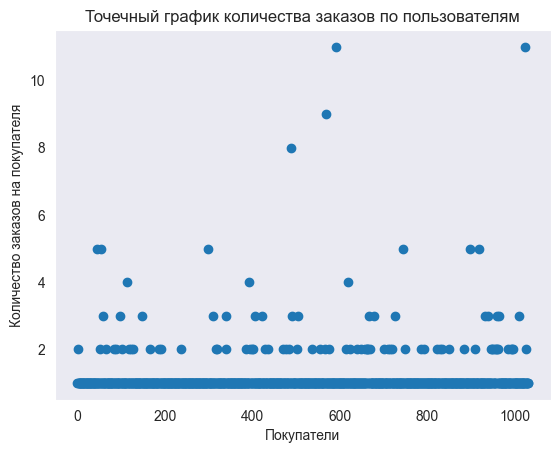

In [61]:
x_values = pd.Series(range(0, len(ordersByUsers)))
plt.scatter(x_values, ordersByUsers['orders']) 
plt.xlabel("Покупатели")
plt.ylabel("Количество заказов на покупателя")
plt.title("Точечный график количества заказов по пользователям")
plt.show()

**Выводы:**   
В основном, преобладающее большинство покупателей оформляют один заказ, чуть реже - 2 заказа. Но встречаются и покупатели, сделавшие пять и более заказов, максимум - 11 заказов.

### 95-й и 99-й перцентили количества заказов на пользователя. <a class="anchor" id="id_3h"></a>

In [62]:
print(np.percentile(ordersByUsers['orders'], [95, 99]))

[2. 4.]


**Выводы:**  
Не более 5% пользователей сделали более 2 заказов и не более 1% - более 4х заказов. Аномальными будем считать пользователей, которые сделали более 4 заказов.

### Tочечный график стоимостей заказов. <a class="anchor" id="id_3j"></a>

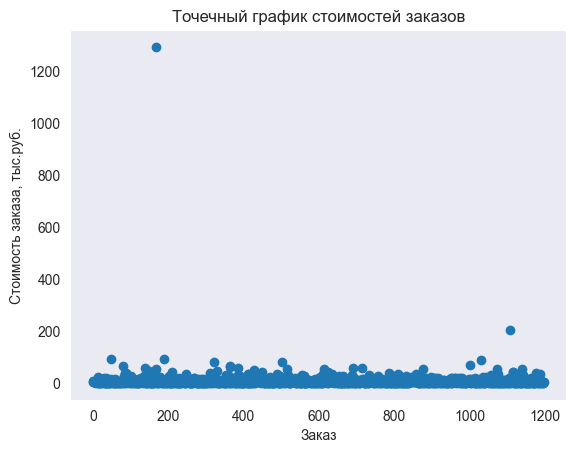

In [63]:
revenueByOrder = orders.groupby('transactionId').agg({'revenue':'sum','group':'max'})
x_values = pd.Series(range(0, len(revenueByOrder['revenue'])))
plt.scatter(x_values, revenueByOrder['revenue']/1000)
plt.xlabel("Заказ")
plt.ylabel("Стоимость заказа, тыс.руб.")
plt.title("Tочечный график стоимостей заказов")
plt.show()


### 95-й и 99-й перцентили стоимости заказов  <a class="anchor" id="id_3k"></a>

In [64]:
# Посчитаем выборочные перцентили
print(np.percentile(revenueByOrder['revenue'], [95, 99]))

[28000.  58233.2]


**Выводы:**  
Не более 5% покупателей сделали заказ более 28000 рублей и не более 1% - на сумму более 58233 рублей. Аномальными буду считать значения более 50 000 рублей. Так я уберу 1% покупателей, сделавших заказы более 58233 рублей, а также от 1 до 5% покупателей сделавших заказы более 28 тр.

### Cтатистическая значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным. <a class="anchor" id="id_3l"></a>

Формулировка гипотез: 
 - Нулевая: различий в среднем количестве заказов между группами в неочищенных данных нет.
 - Альтернативная: различия в среднем между группами есть.
 
Критерий статистической значимости $\alpha=0.01$  
Так как в наблюдениях есть большие выбросы следует использовать непараметрический тест Уилкоксона-Манна-Уитни для сравнения двух групп.

Выборка количества заказов на посетителя по группам: 

In [65]:
ordersByUsersA = ordersByUsers.query('group=="A"')
ordersByUsersB = ordersByUsers.query('group=="B"')

Переменные sampleA и sampleB содержат количество заказов по пользователям из обеих групп. Тем, кто ничего не заказал, будут соответствовать нули. Это нужно, чтобы подготовить выборки к проверке критерием Манна-Уитни.  
Переменная sampleA состоит из двух частей:  
 - Список с количеством заказов для каждого из пользователей: ordersByUsersA['orders'].
 - Нули для пользователей, которые ничего не заказывали. Их количество равно разнице между суммой посетителей и количеством записей о заказах:  
data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders']).  
Аналогично с sampleB.


In [66]:
sampleA = pd.concat([ordersByUsersA['orders'],
                     pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])),
                               name='orders')],axis=0) 
sampleB = pd.concat([ordersByUsersB['orders'],
                     pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])),
                               name='orders')],axis=0) 

Число строк sampleA — это количество пользователей, сумма всех элементов — количество заказов. Чтобы получить среднее число заказов на пользователя, поделим сумму заказов на число пользователей, используя метод mean().   
Выведу относительный прирост среднего числа заказов группы B:  
*среднее число заказов группы B / среднее число заказов группы A - 1.*

In [67]:
print('p-value: ',"{0:.5f}".format(st.mannwhitneyu(sampleA, sampleB)[1]))
print('Относительный прирост среднего числа заказов группы B: ',"{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

p-value:  0.00001
Относительный прирост среднего числа заказов группы B:  0.543


**Вывод**  
P -value значительно меньше 0.01, поэтому нулевая гипотеза отвергается. Анализ сырых данных показал, что в среднем количестве заказов между группами есть статистически значимые различия. Относительный прирост среднего количества заказов группы В к среднему количеству заказов группы А составил 54.3%

### Статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным.  <a class="anchor" id="id_3m"></a>

Формулировка гипотез:  
 - Нулевая гипотеза: различий в среднем чеке между группами в неочищенных данных нет.
 - Альтернативная гипотеза: различия в среднем чеке между группами есть.
 
Критерий статистической значимости $\alpha=0.05$

In [68]:
sampleA = revenueByOrder.query('group=="A"')['revenue']
sampleB = revenueByOrder.query('group=="B"')['revenue']

In [69]:
print('p-value: ',"{0:.5f}".format(st.mannwhitneyu(sampleA, sampleB)[1]))
print('Относительный прирост среднего чека группы B: ',"{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

p-value:  0.72929
Относительный прирост среднего чека группы B:  0.259


**Вывод**  
P -value значительно больше 0.05, поэтому нулевая гипотеза не отвергается. Анализ сырых данных показал, что в среднем чеке между группами нет статистически значимых различий. Относительный прирост среднего чека группы В к среднему чеку группы А составил 25.9%

### Cтатистическая значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным <a class="anchor" id="id_3n"></a>

Аномальными будут считаться покупатели:    
 - сделавшие покупки на сумму более 50 000 рублей.
 - сделавшие более 4 заказов.
 
Формулировка гипотез: 
 - Нулевая: различий в  среднем количестве заказов на посетителя между группами в очищенных данных нет.
 - Альтернативная: различия в среднем количестве заказов на посетителя между группами в очищенных данных есть.
 
Критерий статистической значимости $\alpha=0.01$

Создание таблицы данных аномальных покупателей:

In [70]:
#Таблица покупателей с заказами более 4
usersWithManyOrders = pd.concat([ordersByUsersA[ordersByUsersA['orders'] > 4]['visitorId'],
                                 ordersByUsersB[ordersByUsersB['orders'] > 4]['visitorId']],
                                axis=0)
#Таблица покупателей с заказами свыше 50 000 рублей
usersWithExpensiveOrders = orders[orders['revenue'] > 50000]['visitorId']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    
)
print(abnormalUsers.head(5))
print(abnormalUsers.shape[0])

44      199603092
55      237748145
299    1230306981
487    2038680547
569    2378935119
Name: visitorId, dtype: int64
27


Всего 27 аномальных покупателей.  
Создание выборок по группам с очищенными данными по такому же методу, как при вычислении статистической значимости различий в среднем количестве заказов на посетителя между группами по «сырым» данным:

In [71]:
sampleAFiltered = pd.concat([ordersByUsersA[np.logical_not(ordersByUsersA['visitorId'].isin(abnormalUsers))]['orders'],
                             pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])),
                                       name='orders')],
                            axis=0)

sampleBFiltered = pd.concat([ordersByUsersB[np.logical_not(ordersByUsersB['visitorId'].isin(abnormalUsers))]['orders'],
                             pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])),
                                       name='orders')],
                            axis=0)


In [72]:
print('p-value: ',"{0:.5f}".format(st.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('Относительный прирост среднего числа заказов группы B: ',"{0:.3f}".format(sampleBFiltered.mean() / sampleAFiltered.mean() - 1))

p-value:  0.00004
Относительный прирост среднего числа заказов группы B:  0.406


**Вывод**    
P -value значительно меньше 0.01, поэтому нулевая гипотеза отвергается. Анализ очищенных данных показал, что в среднем количестве заказов между группами есть статистически значимые различия. Относительный прирост среднего группы В к среднему группы А составил 40.6%. Исключение аномальных значений позволило уточнить последний показатель на 14%.  


### Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным.  <a class="anchor" id="id_3o"></a>

Формулировка гипотез: 
 - Нулевая: различий в в среднем чеке заказов между группами в очищенных данных нет.
 - Альтернативная: различия в среднем чеке заказов между группами в очищенных данных есть.
 
Критерий статистической значимости $\alpha=0.05$

Создание очищенных выборок:

In [73]:
#sampleAFiltered содержит visitorIds не присутствующие в таблице abnormalUsers и включенные в группу А
sampleAFiltered = orders[
    np.logical_and(orders['group'] == 'A', 
                   np.logical_not(orders['visitorId'].isin(abnormalUsers)))
                        ]['revenue']
# То же самое для группы B
sampleBFiltered = orders[
    np.logical_and(orders['group'] == 'B', 
                   np.logical_not(orders['visitorId'].isin(abnormalUsers)))
                        ]['revenue']


In [74]:
print('p-value: ',"{0:.5f}".format(st.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('Относительный прирост среднего чека группы B: ',"{0:.3f}".format(sampleBFiltered.mean() / sampleAFiltered.mean() - 1))

p-value:  0.81693
Относительный прирост среднего чека группы B:  0.024


**Вывод**      
P -value значительно больше 0.05, поэтому нулевая гипотеза не отвергается. Анализ очищенных данных показал, что в среднем чеке между группами в очищенных данных нет статистически значимых различий. Относительный прирост среднего чека группы В к среднему чеку группы А составил 2.4% вместо 25.9% в неочищенных данных.

Примите решение по результатам теста и объясните его. Варианты решений:
1. Остановить тест, зафиксировать победу одной из групп.
2. Остановить тест, зафиксировать отсутствие различий между группами.
3. Продолжить тест.

## Общий вывод <a class="anchor" id="id_4"></a> 

По результата АВ-теста можно заключить,что:
 - Входные данные повыручке (revenue) и числу посетителей (visitors) не распределены нормально и содержат выбросы.
 - Посетители правильно распределены по группам, количество участников в тесте удовлетворяет превысило оптимальное количество в 32634 человека и составило 37652.
 - Конверсия у группы В к концу теста примерно на 15% лучше, чем конверсия группы A.  
 - Есть статистическая разница между группами по метрике среднего количества заказов на одного покупателя до и после очистки от аномальных значений. После удаления выбросов дисперсия в данных снизилась и данный показатель в группе B на 40% превысил его значение в группе A. И то, что все покупатели с заказами более 4 находятся в группе В - это заслуга эксперимента, а не случайность.

In [75]:
print(ordersByUsersB.query('orders>4').shape[0])
print(ordersByUsersA.query('orders>4').shape[0])

10
0


 - Также по графику кумулятивного среднего количества заказов на посетителя по группам видно, что линии устаканиваются к концу наблюдений и значение группы В, начиная с 6 дня эксперимента начинает превалировать и это неслучайно.

 - По метрике среднего чека нет статистической разницы до и после очистки. В группу B попало много аномальных значений и после очистки ее показатель относительного прироста группы B над группой A опустился с 25.9% до 2.4%. Поэтому по ее графикам нельзя сделать какие-либо выводы. 

Исходя из этого я принял решение остановить тест и признать его успешным, так как он позволил улучшить одну метрику, от которой зависит выручка.